# Setup

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
from tensorflow.keras.models import clone_model

2023-11-22 03:11:09.479909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 03:11:09.605740: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-22 03:11:10.136202: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-22 03:11:10.136268: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
DIR_AMAZON = "office31/amazon"
DIR_DSLR = "office31/dslr"
DIR_WEBCAM = "office31/webcam"

BATCH_SIZE = 64
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_DIM = 3

EPOCHS = 100

# W_CATEGORICAL = 0.1
# W_ADVERSARIAL = 0
# W_DOMAIN      = 1

SOURCE = DIR_DSLR
TARGET = DIR_WEBCAM

latent_dim = 128

dataset_source = tf.keras.utils.image_dataset_from_directory(
  SOURCE,                                                     # change DIR according to the dataset
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

dataset_source_val = tf.keras.utils.image_dataset_from_directory(
  SOURCE,                                                     # change DIR according to the dataset
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

dataset_target = tf.keras.utils.image_dataset_from_directory(
  TARGET,                                                     # change DIR according to the dataset
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

normalization_layer = tf.keras.layers.Rescaling(1./255)

dataset_source = dataset_source.map(lambda x, y: (normalization_layer(x), y))
dataset_source_val = dataset_source_val.map(lambda x, y: (normalization_layer(x), y))
dataset_target = dataset_target.map(lambda x, y: (normalization_layer(x), y))

dataset = tf.data.Dataset.zip((dataset_source, dataset_source_val, dataset_target))


Found 498 files belonging to 31 classes.
Using 399 files for training.


2023-11-22 03:11:10.947145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 03:11:11.545122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22822 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:37:00.0, compute capability: 7.5


Found 498 files belonging to 31 classes.
Using 99 files for validation.
Found 795 files belonging to 31 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Preparation Part

In [3]:
@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)

In [4]:

# @tf.function
def train_step(real_images, real_label, test_images, test_label, target_images, target_label):
# def train_step(d_optimizer, g_optimizer, c_optimizer, fe_optimizer, domain_optimizer, feature_extractor, categorical_classifier, domain_classifier, generator, discriminator, real_images, real_label, test_images, test_label, target_images, target_label):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(BATCH_SIZE, latent_dim))
    # Decode them to fake images
    generated_images = generator(random_latent_vectors)
    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((BATCH_SIZE, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(labels.shape)

    combined_domain = tf.concat([target_images, real_images], axis=0)

    # Assemble labels classifying target from source images
    labels_domain = tf.concat(
        [tf.ones((target_images.shape[0], 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels_domain += 0.05 * tf.random.uniform(labels_domain.shape)

    # Train the discriminator
    with tf.GradientTape(persistent=True) as tape:
        features = feature_extractor(combined_images)
        predictions_disc = discriminator(features)
        # predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions_disc)

        features = feature_extractor(real_images)
        predictions_clas = categorical_classifier(features)
        # predictions = classifier(real_images)
        c_loss = loss_fn_cls(real_label, predictions_clas)

        features = feature_extractor(combined_domain)
        predictions_domain = domain_classifier(features)
        domain_loss = loss_fn(labels_domain, predictions_domain)
        domain_loss = -1 * domain_loss

        # fe_loss = total_loss(predictions_disc, labels, predictions_clas, real_label)
        fe_loss = W_ADVERSARIAL * d_loss + W_CATEGORICAL * c_loss + W_DOMAIN * domain_loss
        
#     tf.print(fe_loss, d_loss, c_loss, domain_loss)

    grads_feature_extractor = tape.gradient(fe_loss, feature_extractor.trainable_weights)
    fe_optimizer.apply_gradients(zip(grads_feature_extractor, feature_extractor.trainable_weights))

    grads_discriminator = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads_discriminator, discriminator.trainable_weights))

    grads_categorical = tape.gradient(c_loss, categorical_classifier.trainable_weights)
    c_optimizer.apply_gradients(zip(grads_categorical, categorical_classifier.trainable_weights))

    grads_domain = tape.gradient(domain_loss, domain_classifier.trainable_weights)
    domain_optimizer.apply_gradients(zip(grads_domain, domain_classifier.trainable_weights))



    #################################

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(BATCH_SIZE, latent_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((BATCH_SIZE, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        features = feature_extractor(generator(random_latent_vectors))
        predictions = discriminator(features)
        # predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

#     print("##########train step###########")
#     print(feature_extractor.name)
#     print(categorical_classifier.name)
#     print(domain_classifier.name)
#     print(discriminator.name)
#     print(generator.name)

    c_acc_t = train_accuracy(tf.math.argmax(categorical_classifier(feature_extractor(real_images)), 1) , real_label)
    c_acc_v = val_accuracy(tf.math.argmax(categorical_classifier(feature_extractor(test_images)), 1), test_label)
    c_acc_target = target_accuracy(tf.math.argmax(categorical_classifier(feature_extractor(target_images)), 1), target_label)


    return c_acc_target, c_acc_v, c_acc_t, domain_loss, c_loss, d_loss, g_loss, fe_loss

In [5]:
def plot_loss_values(gl_, al_, cl_, dl_, tl_):
    x = np.arange(len(gl_))

    plt.plot(x, gl_, label = "generative loss", linestyle="-.")
    plt.plot(x, al_, label = "adversarial loss", linestyle="-")
    plt.plot(x, cl_, label = "categorical loss", linestyle="--")
    plt.plot(x, dl_, label = "domain loss", linestyle=":")
    plt.plot(x, tl_, label = "total loss", linestyle=(0, (3, 1, 1, 1)))
    plt.legend()
    plt.show()

In [6]:
def plot_acc_values(acc_source_, acc_target_, acc_source_val_):
    x = np.arange(len(acc_source_))
    plt.plot(x, acc_source_, label = "source acc", linestyle="-")
    plt.plot(x, acc_target_, label = "target acc", linestyle=":")
    plt.plot(x, acc_source_val_, label = "val acc", linestyle="-.")
    plt.legend()
    plt.show()

# Training LOOP

In [7]:
def create_feature_extractor():
    feature_extractor = tf.keras.applications.InceptionV3(
        weights='imagenet',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DIM),
        include_top=False)

    feature_extractor.trainable = False

    feature_extractor = keras.Sequential(
        [
            feature_extractor,
            layers.GlobalAveragePooling2D(),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),

        ],
#         name="feature_extractor",
    )
    
    return feature_extractor
    
def create_categorical_cls():
    
    categorical_classifier = keras.Sequential(
        [
            layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
            layers.Dropout(0.3),
            layers.Dense(31, activation='softmax'),
        ],
#         name="categorical_classifier",
    )
    
    return categorical_classifier

def create_domain_cls():
    domain_classifier = keras.Sequential(
        [
            layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
            layers.Dropout(0.3),
            GradReverse(),
            layers.Dense(1),
        ],
#         name="domain_classifier",
    )
    
    return domain_classifier
    
def create_generator():
    generator = keras.Sequential(
        [
            keras.Input(shape=(latent_dim,)),
            # We want to generate 128 coefficients to reshape into a 7x7x128 map
            layers.Dense(8 * 8 * 128),
            layers.LeakyReLU(alpha=0.2),
            layers.Reshape((8, 8, 128)),
            layers.Conv2DTranspose(128, (4, 4), strides=(4, 4), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(128, (4, 4), strides=(4, 4), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            # layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            # layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(3, (8, 8), padding="same", activation="sigmoid"),
        ],
#         name="generator",
    )
    return generator

def crete_discriminator():
    discriminator = keras.Sequential(
        [
            # layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
            # layers.Dropout(0.3),
            layers.Dense(1),
        ],
#         name="discriminator",
    )
    return discriminator

In [8]:
feature_extractor1 = create_feature_extractor()
for x, y in dataset_source.take(1):
    features = feature_extractor1(x)
feature_extractor1.save_weights('feature_extractor.h5')

categorical_classifier1 = create_categorical_cls()
cat_cls = categorical_classifier1(features)
categorical_classifier1.save_weights('categorical_classifier.h5')

domain_classifier1 = create_domain_cls()
dom_cls = domain_classifier1(features)
domain_classifier1.save_weights('domain_classifier.h5')

discriminator1 = crete_discriminator()
disc_cls = discriminator1(features)
discriminator1.save_weights('discriminator.h5')

generator1 = create_generator()
gen_data = generator1(tf.random.normal(shape=(BATCH_SIZE, latent_dim)))
generator1.save_weights('generator.h5')

2023-11-22 03:11:15.296211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-11-22 03:11:15.830838: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [9]:
# W_CATEGORICAL = 0.1
# W_ADVERSARIAL = 0
# W_DOMAIN      = 1

FinalResult = []

scales = np.arange(0,1.1,.5)
scales = [0, 0.1, 0.3, 0.6, 0.01]
# scales = [0.1, 0.3]

for W_CATEGORICAL in scales[-3:]:
    for W_ADVERSARIAL in scales:
        for W_DOMAIN in scales:
            
            feature_extractor = create_feature_extractor()
            feature_extractor.load_weights('feature_extractor.h5')
            for x, y in dataset_source.take(1):
                features = feature_extractor(x)

                
            categorical_classifier = create_categorical_cls()
            cat_cls = categorical_classifier(features)
            categorical_classifier.load_weights('categorical_classifier.h5')
            
            domain_classifier = create_domain_cls()
            dom_cls = domain_classifier(features)
            domain_classifier.load_weights('domain_classifier.h5')
            
            discriminator = crete_discriminator()
            disc_cls = discriminator(features)
            discriminator.load_weights('discriminator.h5')

            generator = create_generator()
            gen_data = generator(tf.random.normal(shape=(BATCH_SIZE, latent_dim)))
            generator.load_weights('generator.h5')
            
            
            
#             print(feature_extractor.name)
#             print(categorical_classifier.name)
#             print(domain_classifier.name)
#             print(discriminator.name)
#             print(generator.name)
#             print("##################")
            
            
            # Instantiate one optimizer for the discriminator and another for the generator.
            d_optimizer = keras.optimizers.Adam()
            g_optimizer = keras.optimizers.Adam()
            c_optimizer = keras.optimizers.Adam()
            fe_optimizer = keras.optimizers.Adam()
            domain_optimizer = keras.optimizers.Adam()
            

            # Instantiate a loss function.
            loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
            loss_fn_cls = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

            val_accuracy = tf.keras.metrics.Accuracy()
            train_accuracy = tf.keras.metrics.Accuracy()
            target_accuracy = tf.keras.metrics.Accuracy()


            ###################################################################

            gl_, al_, cl_, dl_, tl_, acc_source_, acc_target_, acc_source_val_ = [], [], [], [], [], [], [], []
            

            for epoch in range(EPOCHS):

                train_accuracy.reset_state()
                val_accuracy.reset_state()
                target_accuracy.reset_state()


                for step, ((real_images, real_label), (test_images, test_label), (target_images, target_label)) in enumerate(dataset):
                    # Train the discriminator & generator on one batch of real images.
                    acc_target, acc_source_val, acc_source, domain_loss, categorical_loss, adversarial_loss, generative_loss, fe_loss = train_step(real_images, real_label, test_images, test_label, target_images, target_label)
#                     acc_target, acc_source_val, acc_source, domain_loss, categorical_loss, adversarial_loss, generative_loss, fe_loss = train_step(d_optimizer, g_optimizer, c_optimizer, fe_optimizer, domain_optimizer, feature_extractor, categorical_classifier, domain_classifier, generator, discriminator, real_images, real_label, test_images, test_label, target_images, target_label)

                    gl_ += [generative_loss]
                    al_ += [adversarial_loss]
                    cl_ += [categorical_loss]
                    dl_ += [domain_loss]
                    tl_ += [fe_loss]
                    acc_source_ += [acc_source]
                    acc_target_ += [acc_target]
                    acc_source_val_ +=[acc_source_val]

#             plot_loss_values(gl_, al_, cl_, dl_, tl_)
#             plot_acc_values(acc_source_, acc_target_, acc_source_val_)
            
            tempResult = {'W_CATEGORICAL' : W_CATEGORICAL,
                          'W_ADVERSARIAL' : W_ADVERSARIAL,
                          'W_DOMAIN'      : W_DOMAIN,
                          'gl_':gl_, 
                          'al_':al_, 
                          'cl_':cl_, 
                          'dl_':dl_, 
                          'tl_':tl_, 
                          'acc_source_':acc_source_, 
                          'acc_target_':acc_target_, 
                          'acc_source_val_':acc_source_val_}
            FinalResult+=[tempResult]

            # save dictionary to person_data.pkl file
            print('W_CATEGORICAL: ', W_CATEGORICAL,
                  'W_ADVERSARIAL: ' , W_ADVERSARIAL,
                  'W_DOMAIN: ' , W_DOMAIN)
            
#             del feature_extractor
#             del categorical_classifier
#             del domain_classifier
#             del generator
#             del discriminator
            
#             keras.backend.clear_session()
            
#         break   
#     break
            
with open('result.pkl', 'wb') as fp:
    pickle.dump({'result':FinalResult}, fp)

2023-11-22 03:11:23.925895: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x6dc33e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-22 03:11:23.925921: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2023-11-22 03:11:23.930085: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-22 03:11:24.012961: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-22 03:11:24.076980: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0 W_DOMAIN:  0
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0 W_DOMAIN:  0.1
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0 W_DOMAIN:  0.3
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0 W_DOMAIN:  0.6
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0 W_DOMAIN:  0.01
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0.1 W_DOMAIN:  0
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0.1 W_DOMAIN:  0.1
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0.1 W_DOMAIN:  0.3
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0.1 W_DOMAIN:  0.6
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0.1 W_DOMAIN:  0.01
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0.3 W_DOMAIN:  0
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0.3 W_DOMAIN:  0.1
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0.3 W_DOMAIN:  0.3
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0.3 W_DOMAIN:  0.6
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0.3 W_DOMAIN:  0.01
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0.6 W_DOMAIN:  0
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0.6 W_DOMAIN:  0.1
W_CATEGORICAL:  0.3 W_ADVERSARIAL:  0.6 W_DOMAIN:  0.3
W_CATEGORICAL:  0.3 W_ADV

In [10]:
with open('result.pkl', 'wb') as fp:
    pickle.dump({'result':FinalResult}, fp)

In [11]:
import pickle

# Read dictionary pkl file
with open('result.pkl', 'rb') as fp:
    person = pickle.load(fp)
    print('Person dictionary')
#     print(person)

Person dictionary


In [12]:
person['result'][0].keys()

dict_keys(['W_CATEGORICAL', 'W_ADVERSARIAL', 'W_DOMAIN', 'gl_', 'al_', 'cl_', 'dl_', 'tl_', 'acc_source_', 'acc_target_', 'acc_source_val_'])

In [13]:
import numpy as np
import matplotlib.pyplot as plt

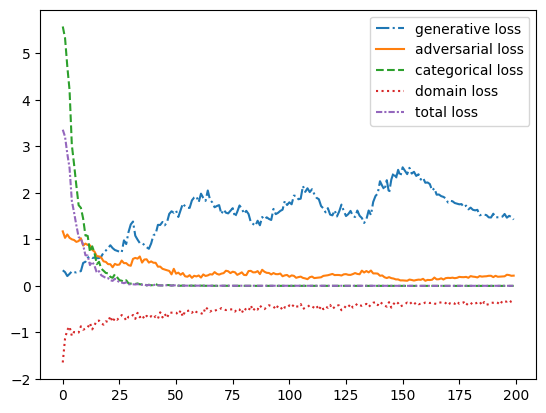

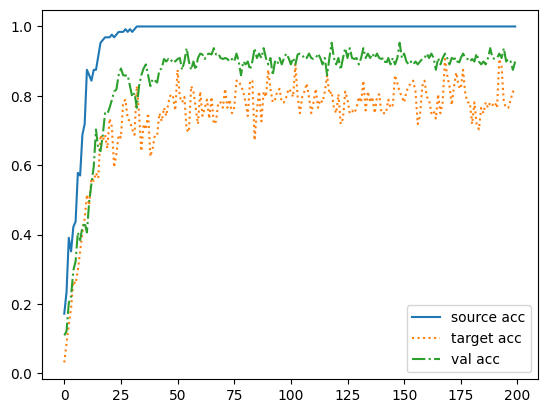

In [14]:
i = 45
plot_loss_values(person['result'][i]['gl_'], person['result'][i]['al_'], person['result'][i]['cl_'], person['result'][i]['dl_'], person['result'][i]['tl_'])
plot_acc_values(person['result'][i]['acc_source_'], person['result'][i]['acc_target_'], person['result'][i]['acc_source_val_'])

W_CATEGORICAL:  0.3
W_ADVERSARIAL:  0
W_DOMAIN:  0


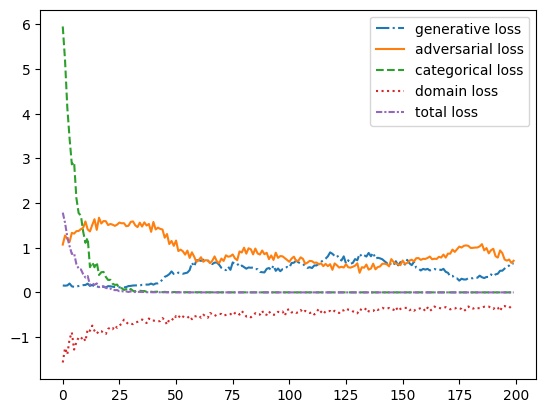

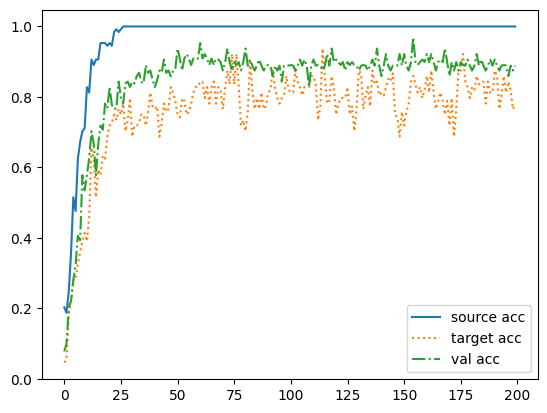

W_CATEGORICAL:  0.3
W_ADVERSARIAL:  0
W_DOMAIN:  0.1


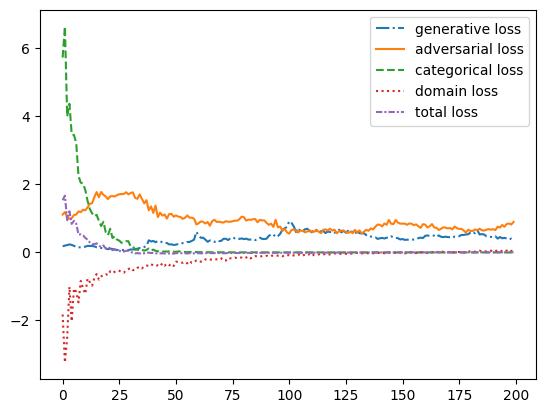

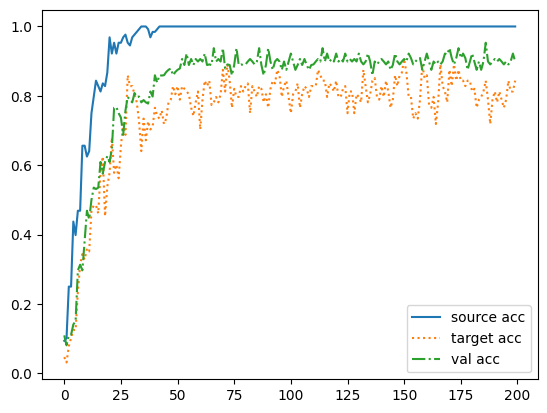

W_CATEGORICAL:  0.3
W_ADVERSARIAL:  0
W_DOMAIN:  0.3


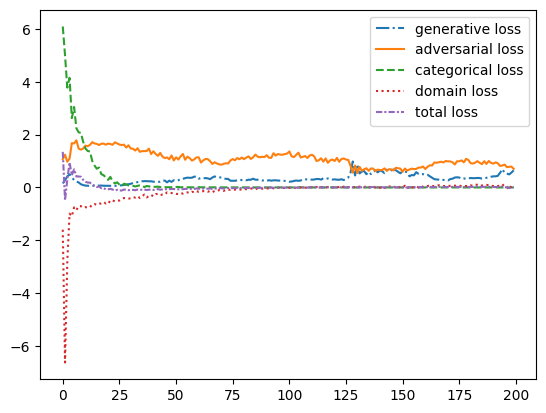

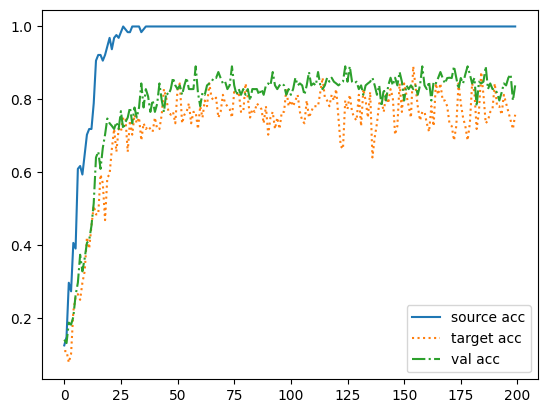

W_CATEGORICAL:  0.3
W_ADVERSARIAL:  0
W_DOMAIN:  0.6


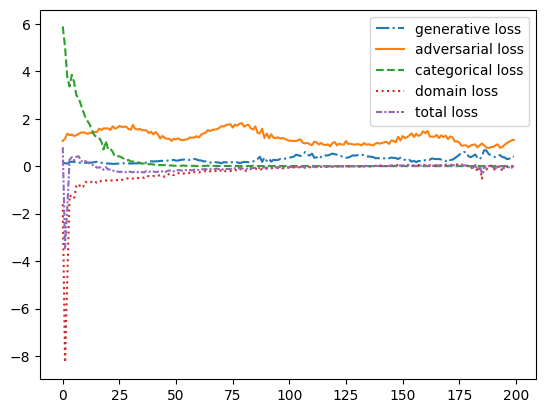

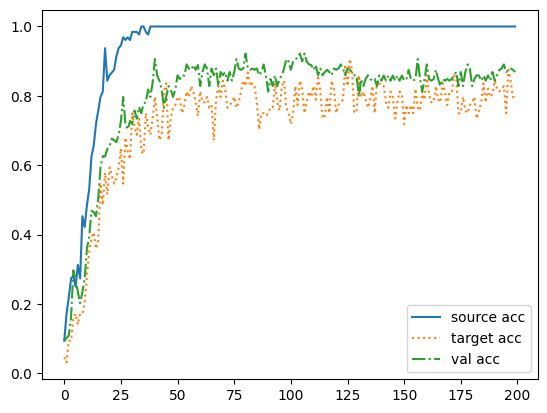

W_CATEGORICAL:  0.3
W_ADVERSARIAL:  0
W_DOMAIN:  0.01


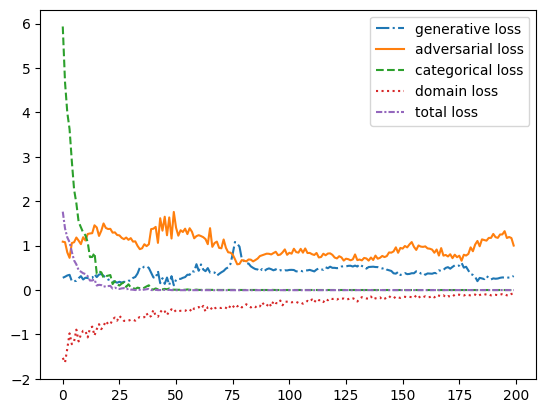

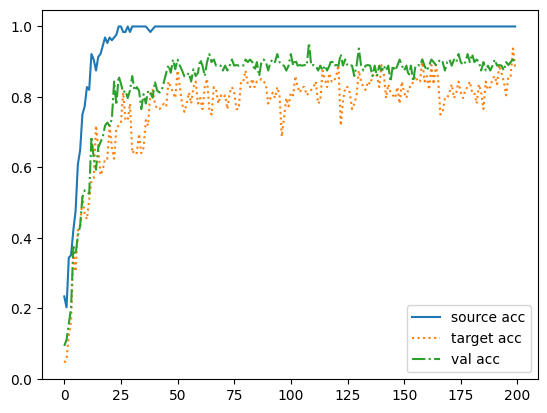

In [15]:
for i in range(5):
    print("W_CATEGORICAL: ", person['result'][i]['W_CATEGORICAL'])
    print("W_ADVERSARIAL: ", person['result'][i]['W_ADVERSARIAL'])
    print("W_DOMAIN: ", person['result'][i]['W_DOMAIN'])
    
    plot_loss_values(person['result'][i]['gl_'], person['result'][i]['al_'], person['result'][i]['cl_'], person['result'][i]['dl_'], person['result'][i]['tl_'])
    plot_acc_values(person['result'][i]['acc_source_'], person['result'][i]['acc_target_'], person['result'][i]['acc_source_val_'])

In [16]:
recap_acc = person['result']

In [17]:
import pandas as pd

df = pd.DataFrame.from_records(recap_acc)
df['gl_'] = df['gl_'].map(lambda x: x[-1].numpy())
df['al_'] = df['al_'].map(lambda x: x[-1].numpy())
df['cl_'] = df['cl_'].map(lambda x: x[-1].numpy())
df['dl_'] = df['dl_'].map(lambda x: x[-1].numpy())
df['tl_'] = df['tl_'].map(lambda x: x[-1].numpy())

df['acc_source_'] = df['acc_source_'].map(lambda x: x[-1].numpy())
df['acc_target_'] = df['acc_target_'].map(lambda x: x[-1].numpy())
df['acc_source_val_'] = df['acc_source_val_'].map(lambda x: x[-1].numpy())

In [18]:
df.tail()

,W_CATEGORICAL,W_ADVERSARIAL,W_DOMAIN,gl_,al_,cl_,dl_,tl_,acc_source_,acc_target_,acc_source_val_
70,0.01,0.01,0.00,21.029957,-0.096922,0.001083,-0.442298,-0.000958,1.0,0.757812,0.828283
71,0.01,0.01,0.10,4.407324,0.063678,0.010575,0.009951,0.001738,1.0,0.695312,0.878788
72,0.01,0.01,0.30,6.977318,0.042540,0.045915,0.011673,0.004387,1.0,0.664062,0.848485
73,0.01,0.01,0.60,3.346294,0.203725,0.119740,-0.025064,-0.011804,1.0,0.648438,0.767677
74,0.01,0.01,0.01,38.534668,-0.352489,0.001058,0.068101,-0.002833,1.0,0.789062,0.878788


In [19]:
df.style.background_gradient(cmap ='coolwarm') 

,W_CATEGORICAL,W_ADVERSARIAL,W_DOMAIN,gl_,al_,cl_,dl_,tl_,acc_source_,acc_target_,acc_source_val_
0,0.300000,0.000000,0.000000,0.645282,0.708361,0.000476,-0.351001,0.000143,1.000000,0.781250,0.888889
1,0.300000,0.000000,0.100000,0.362375,0.899541,0.000931,0.055798,0.005859,1.000000,0.843750,0.898990
2,0.300000,0.000000,0.300000,0.651104,0.705840,0.001433,-0.011062,-0.002889,1.000000,0.757812,0.838384
3,0.300000,0.000000,0.600000,0.398570,1.111305,0.004534,0.042688,0.026973,1.000000,0.796875,0.868687
4,0.300000,0.000000,0.010000,0.317316,1.002126,0.000611,-0.070733,-0.000524,1.000000,0.882812,0.898990
5,0.300000,0.100000,0.000000,20.317242,-0.093346,0.001438,-0.409596,-0.008903,1.000000,0.750000,0.878788
6,0.300000,0.100000,0.100000,2.613875,0.072268,0.000808,0.052123,0.012681,1.000000,0.812500,0.929293
7,0.300000,0.100000,0.300000,18.008068,-0.110245,0.001030,0.065374,0.008897,1.000000,0.828125,0.848485
8,0.300000,0.100000,0.600000,2.126101,0.118459,0.006587,-0.063246,-0.024126,1.000000,0.710938,0.808081
9,0.300000,0.100000,0.010000,6.122615,0.101096,0.001034,-0.149036,0.008929,1.000000,0.843750,0.858586


In [20]:
df.describe()

,W_CATEGORICAL,W_ADVERSARIAL,W_DOMAIN,gl_,al_,cl_,dl_,tl_,acc_source_,acc_target_,acc_source_val_
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.0,75.000000,75.000000
mean,0.303333,0.202000,0.202000,15.203000,0.133190,0.011805,-0.097204,-0.035085,1.0,0.772292,0.856835
std,0.242500,0.227834,0.227834,20.779440,0.469945,0.023626,0.170301,0.116061,0.0,0.060919,0.037735
min,0.010000,0.000000,0.000000,0.309615,-1.065251,0.000352,-0.503541,-0.693188,1.0,0.617188,0.757576
25%,0.010000,0.010000,0.010000,1.768600,-0.099256,0.000852,-0.166721,-0.031446,1.0,0.718750,0.838384
50%,0.300000,0.100000,0.100000,7.879406,-0.000442,0.001426,-0.025064,-0.001183,1.0,0.781250,0.868687
75%,0.600000,0.300000,0.300000,20.538101,0.208518,0.007796,0.034289,0.004550,1.0,0.816406,0.883838
max,0.600000,0.600000,0.600000,118.205185,1.441932,0.119740,0.070246,0.053048,1.0,0.890625,0.929293


In [21]:
df[['W_CATEGORICAL', 'W_ADVERSARIAL', 'W_DOMAIN','acc_source_', 'acc_target_', 'acc_source_val_']].corr().style.background_gradient(cmap ='coolwarm') 

/home/dcsmahasiswa1/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/dcsmahasiswa1/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,W_CATEGORICAL,W_ADVERSARIAL,W_DOMAIN,acc_source_,acc_target_,acc_source_val_
W_CATEGORICAL,1.000000,-0.000000,-0.000000,nan,0.491944,0.547197
W_ADVERSARIAL,-0.000000,1.000000,0.000000,nan,-0.155159,-0.232503
W_DOMAIN,-0.000000,0.000000,1.000000,nan,-0.461933,-0.204877
acc_source_,nan,nan,nan,nan,nan,nan
acc_target_,0.491944,-0.155159,-0.461933,nan,1.000000,0.570179
acc_source_val_,0.547197,-0.232503,-0.204877,nan,0.570179,1.000000


In [22]:
df[['W_CATEGORICAL', 'W_ADVERSARIAL', 'W_DOMAIN','gl_', 'al_', 'cl_', 'dl_', 'tl_']].corr().style.background_gradient(cmap ='coolwarm') 

,W_CATEGORICAL,W_ADVERSARIAL,W_DOMAIN,gl_,al_,cl_,dl_,tl_
W_CATEGORICAL,1.000000,-0.000000,-0.000000,-0.043653,-0.031325,-0.549627,0.008420,-0.028690
W_ADVERSARIAL,-0.000000,1.000000,0.000000,0.585374,-0.608362,0.059891,-0.100928,-0.512562
W_DOMAIN,-0.000000,0.000000,1.000000,-0.101458,0.056180,0.414086,0.560038,0.060943
gl_,-0.043653,0.585374,-0.101458,1.000000,-0.719592,-0.006538,-0.152848,-0.906591
al_,-0.031325,-0.608362,0.056180,-0.719592,1.000000,-0.000455,0.065804,0.548670
cl_,-0.549627,0.059891,0.414086,-0.006538,-0.000455,1.000000,0.162904,0.008127
dl_,0.008420,-0.100928,0.560038,-0.152848,0.065804,0.162904,1.000000,0.171818
tl_,-0.028690,-0.512562,0.060943,-0.906591,0.548670,0.008127,0.171818,1.000000
